# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [2]:
EXECUTE_ON_COLAB = False

In [31]:
import os
import hdf5plugin
import h5py
import json
import time
import zipfile
import tables
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Resizing, Conv2D, BatchNormalization, Multiply
from keras import backend as K

if(EXECUTE_ON_COLAB):
    from google.colab import drive
    drive.mount('/content/drive')

## 2 - Neural Network Model (VoasCNN)

In [4]:
SAVE_MODEL = False
LOAD_MODEL = True
TRAINING = False
EVALUATE = False

In [5]:
EPOCHS = 15
COLD_PAUSE_BETWEEN_EPOCHS = False
TRAINING_DTYPE = tf.float16
SPLIT_SIZE = 256
BATCH_SIZE = 24
RESIZING_FILTER = 'bilinear'

In [6]:
def voas_cnn_model():
    x_in = Input(shape=(360, SPLIT_SIZE, 1))

    x = Resizing(90, int(SPLIT_SIZE/2), RESIZING_FILTER)(x_in)
    
    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)
    
    x = BatchNormalization()(x)

    ## "masking" original input with trained data

    x = Resizing(360, SPLIT_SIZE, RESIZING_FILTER)(x)

    x = Multiply()([x, x_in])

    ## start four branches now

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    #y1 = Resizing(360, SPLIT_SIZE, RESIZING_FILTER)(y1)
    #y1 = Multiply()([y1, x_in])
    y1 = tf.squeeze(y1, axis=-1, name='sop')

    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    #y2 = Resizing(360, SPLIT_SIZE, RESIZING_FILTER)(y2)
    #y2 = Multiply()([y2, x_in])
    y2 = tf.squeeze(y2, axis=-1, name='alt')

    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    #y3 = Resizing(360, SPLIT_SIZE, RESIZING_FILTER)(y3)
    #y3 = Multiply()([y3, x_in])
    y3 = tf.squeeze(y3, axis=-1, name='ten')

    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    #y4 = Resizing(360, SPLIT_SIZE, RESIZING_FILTER)(y4)
    #y4 = Multiply()([y4, x_in])
    y4 = tf.squeeze(y4, axis=-1, name='bas')

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 3 - Auxiliar functions and Variables

Functions designed to manipulate the SSCS dataset.

### 3.1 - File path variables

In [7]:
if(EXECUTE_ON_COLAB):
    dataset_dir = "/content/Datasets/"
    checkpoint_dir = "/content/drive/MyDrive/SSCS/Checkpoints/sscs.ckpt"
else:
    dataset_dir = "Datasets/"
    checkpoint_dir = "Checkpoints/voas_cnn.keras"
zipname = dataset_dir + "SSCS_HDF5.zip"
sscs_dir = dataset_dir + "SSCS_HDF5/"

songs_dir = sscs_dir + "sscs/"
splitname = sscs_dir + "sscs_splits.json"

### 3.2 - Download/Extract Scripts

In [8]:
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
            
    print()

In [9]:
def sscs_download():
    
    if(not os.path.exists(dataset_dir)):
        os.mkdir(dataset_dir)
   
    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://github.com/Xornotor/SSCS_HDF5/releases/download/v1.0/SSCS_HDF5.zip"
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    if(not os.path.exists(sscs_dir)):
        print("Extracting SSCS Dataset...")
        with zipfile.ZipFile(zipname) as zf:
            os.mkdir(sscs_dir)
            zf.extractall(path=sscs_dir)
    else:
        print("SSCS Dataset already extracted.")
    
    print("Done.")

### 3.3 - Splits, songnames and songlists

In [10]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        split_list = json.load(open(splitname, 'r'))[split.lower()]
        return split_list
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [11]:
def sscs_pick_songlist(first=0, amount=5, split='train'):
    
    songnames = sscs_get_split(split)
    return songnames[first:first+amount]

In [12]:
def sscs_pick_random_song(split='train'):
    
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [13]:
def sscs_pick_multiple_random_songs(amount, split='train'):
    
    return [sscs_pick_random_song() for i in range(amount)]

### 3.4 - Plots

In [14]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

## 4 - Download and extract dataset SSCS

In [15]:
sscs_download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 5 - Dataset Generator

In [16]:
class SSCS_Sequence(tf.keras.utils.Sequence):
    
    ############################################################

    def __init__(self,
                 filenames,
                 batch_size=BATCH_SIZE,
                 split_size=SPLIT_SIZE,
                 training_dtype=TRAINING_DTYPE):

        if(isinstance(filenames, np.ndarray)):
            self.filenames = [f.decode('utf-8') for f in filenames.tolist()]
        else:
            self.filenames = filenames

        self.batch_size = batch_size
        self.batches_amount = 0
        self.splits_per_file = np.array([], dtype=np.intc)
        self.songs_dir = songs_dir
        self.split_size = split_size
        self.idx_get = np.array([], dtype=np.intc)
        self.split_get = np.array([], dtype=np.intc)
        self.training_dtype = training_dtype

        for file in self.filenames:

            file_access = f"{self.songs_dir}{file}.h5"
            f = h5py.File(file_access, 'r')
            file_shape = f['mix/table'].shape[0]
            df_batch_items = file_shape//self.split_size
            #if(file_shape/self.split_size > df_batch_items): df_batch_items += 1
            self.splits_per_file = np.append(self.splits_per_file, int(df_batch_items))
            tmp_idx_get = np.array([self.filenames.index(file) for i in range(df_batch_items)], dtype=np.intc)
            tmp_split_get = np.array([i for i in range(df_batch_items)], dtype=np.intc)
            self.idx_get = np.append(self.idx_get, tmp_idx_get)
            self.split_get = np.append(self.split_get, tmp_split_get)
            f.close()
        
        self.batches_amount = self.split_get.shape[0]//self.batch_size
        if self.batches_amount < self.split_get.shape[0]/self.batch_size: 
            self.batches_amount += 1

        self.idx_get = np.resize(self.idx_get, self.batches_amount * self.batch_size)
        self.idx_get = np.reshape(self.idx_get, (-1, self.batch_size))

        self.split_get = np.resize(self.split_get, self.batches_amount * self.batch_size)
        self.split_get = np.reshape(self.split_get, (-1, self.batch_size))
     
    ############################################################

    def __len__(self):

        return self.batches_amount
    
    ############################################################

    def __getitem__(self, idx):

        tmp_idx = self.idx_get[idx]
        tmp_split = self.split_get[idx]

        batch_splits = np.array(list(map(self.get_split, tmp_idx, tmp_split)))

        splits = [tf.convert_to_tensor(batch_splits[:, i], dtype=self.training_dtype) for i in range(5)]

        return splits[0], (splits[1], splits[2], splits[3], splits[4]) # mix, (s, a, t, b)
    
    ############################################################
    
    def get_split(self, idx, split):

        file_access = f"{self.songs_dir}{self.filenames[idx]}.h5"
        data_min = split * self.split_size
        data_max = data_min + self.split_size
        voices = ['mix', 'soprano', 'alto', 'tenor', 'bass']

        def read_split(voice):

            f = h5py.File(file_access, 'r')

            data = np.transpose(np.array([line[1] for line in f[voice + "/table"][data_min:data_max]]))
            data = data.reshape((data.shape[0], data.shape[1], 1))

            f.close()

            return data

        splits = list(map(read_split, voices))

        return splits # mix, soprano, alto, tenor, bass
    
    ############################################################

    def get_splits_per_file(self):
        
        return self.splits_per_file

In [17]:
seq = SSCS_Sequence(sscs_get_split()[:5])
mix_test, satb_test = seq.__getitem__(2)

'''
print(seq.__len__())
sscs_plot(mix_test.numpy()[28])
sscs_plot(satb_test[0].numpy()[28])
sscs_plot(satb_test[1].numpy()[28])
sscs_plot(satb_test[2].numpy()[28])
sscs_plot(satb_test[3].numpy()[28])
'''

2023-06-25 17:02:47.713781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 17:02:47.784059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 17:02:47.784130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 17:02:47.788301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 17:02:47.788374: I tensorflow/compile

'\nprint(seq.__len__())\nsscs_plot(mix_test.numpy()[28])\nsscs_plot(satb_test[0].numpy()[28])\nsscs_plot(satb_test[1].numpy()[28])\nsscs_plot(satb_test[2].numpy()[28])\nsscs_plot(satb_test[3].numpy()[28])\n'

## 6 - Training VoasCNN

In [18]:
ds_spec = tf.TensorSpec(shape=mix_test.shape, dtype=TRAINING_DTYPE)

signature = (ds_spec, (ds_spec, ds_spec, ds_spec, ds_spec))

ds_train = tf.data.Dataset.from_generator(SSCS_Sequence,
                                    args = [sscs_get_split()[:1000]],
                                    output_signature=signature
                                    ).shuffle(10, reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

ds_val = tf.data.Dataset.from_generator(SSCS_Sequence,
                                    args = [sscs_get_split('validate')[:300]],
                                    output_signature=signature
                                    ).prefetch(tf.data.AUTOTUNE)

ds_test = tf.data.Dataset.from_generator(SSCS_Sequence,
                                    args = [sscs_get_split('test')[:300]],
                                    output_signature=signature
                                    ).prefetch(tf.data.AUTOTUNE)

In [19]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [20]:
save_cb = tf.keras.callbacks.ModelCheckpoint(   filepath=checkpoint_dir,
                                                save_weights_only=True,
                                                verbose=1
                                            )

In [21]:
voas_cnn = voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=2e-3),
                 loss=BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE),
                 metrics=[f1])

#print(voas_cnn.summary())

if(LOAD_MODEL and os.path.exists(checkpoint_dir)):
    voas_cnn.load_weights(checkpoint_dir)

if(TRAINING):
    
        if(COLD_PAUSE_BETWEEN_EPOCHS):
            for epoch in range(EPOCHS):
                if(SAVE_MODEL):
                    voas_cnn.fit(ds_train,
                                epochs=1,
                                callbacks=[save_cb],
                                validation_data=ds_val)
                else:
                    voas_cnn.fit(ds_train,
                                epochs=1,
                                validation_data=ds_val)
                if(epoch < EPOCHS - 1):
                    print("Pausa para resfriar...")
                    time.sleep(120)
        else:
            if(SAVE_MODEL):
                voas_cnn.fit(ds_train,
                            epochs=EPOCHS,
                            callbacks=[save_cb],
                            validation_data=ds_val)
            else:
                voas_cnn.fit(ds_train,
                            epochs=EPOCHS,
                            validation_data=ds_val)

        

## 7 - Evaluating Trained VoasCNN

In [22]:
if(EVALUATE):
    evaluation = voas_cnn.evaluate(ds_test)

## 8 - Evaluation w/ argmax and thresholding

In [23]:
#apply argmax and thresholding to machine output
#evaluate metrics

## 9 - Playground

1/1 [==============================] - 0s 47ms/step


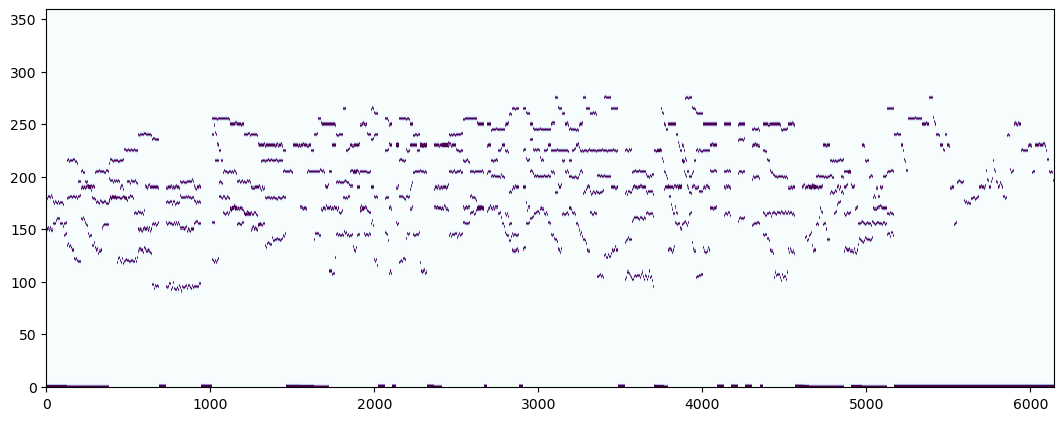

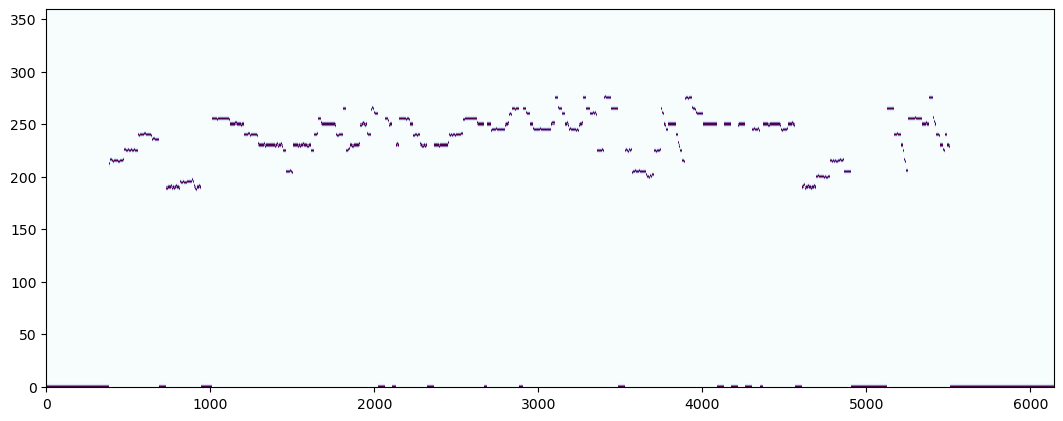

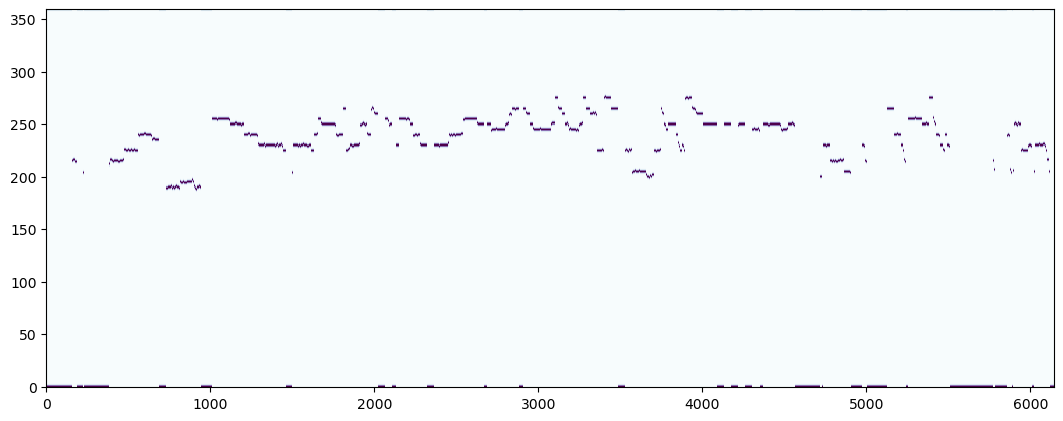

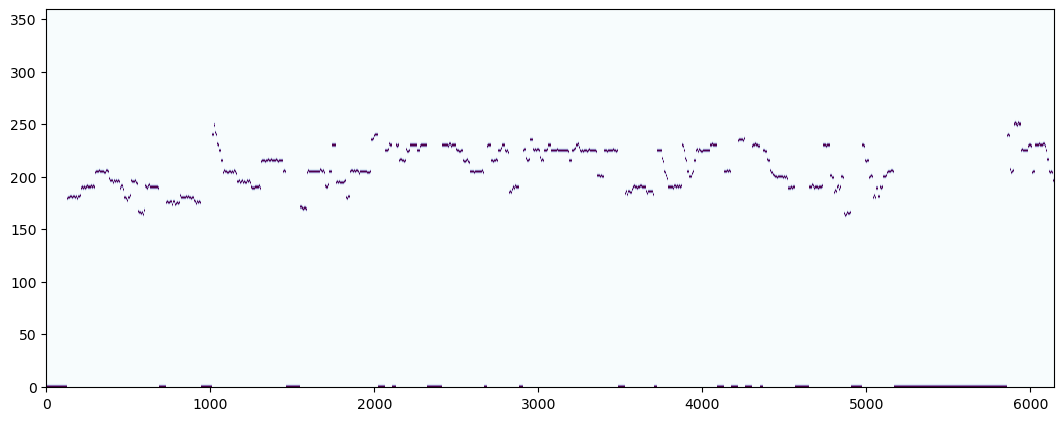

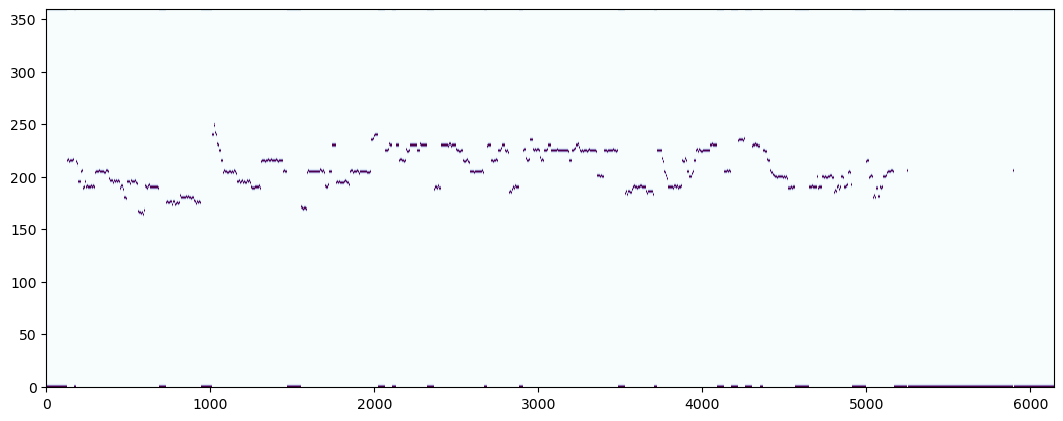

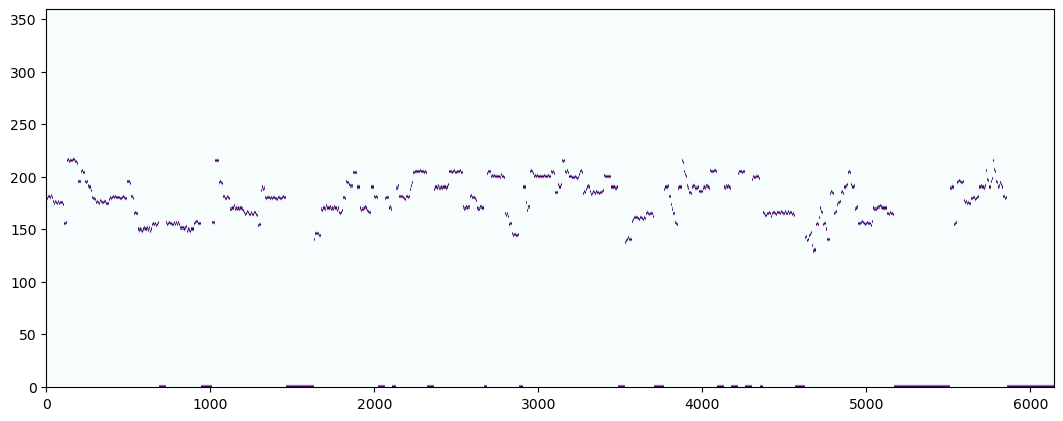

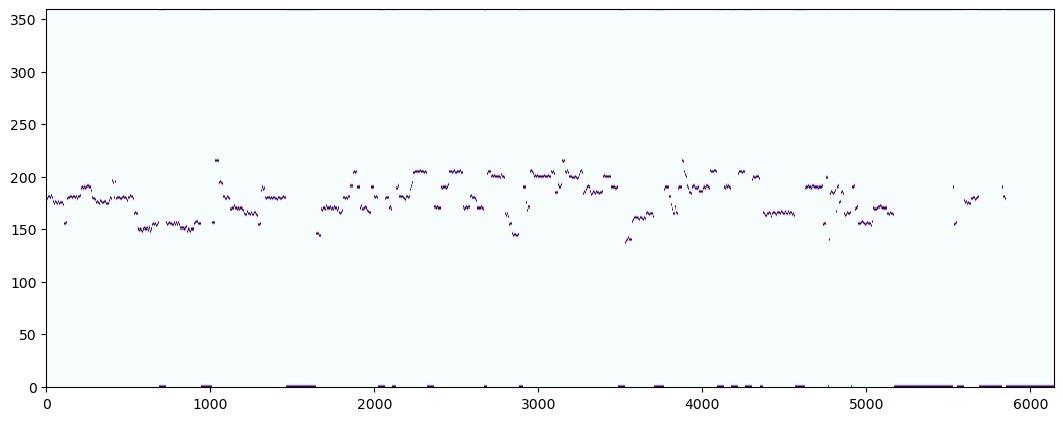

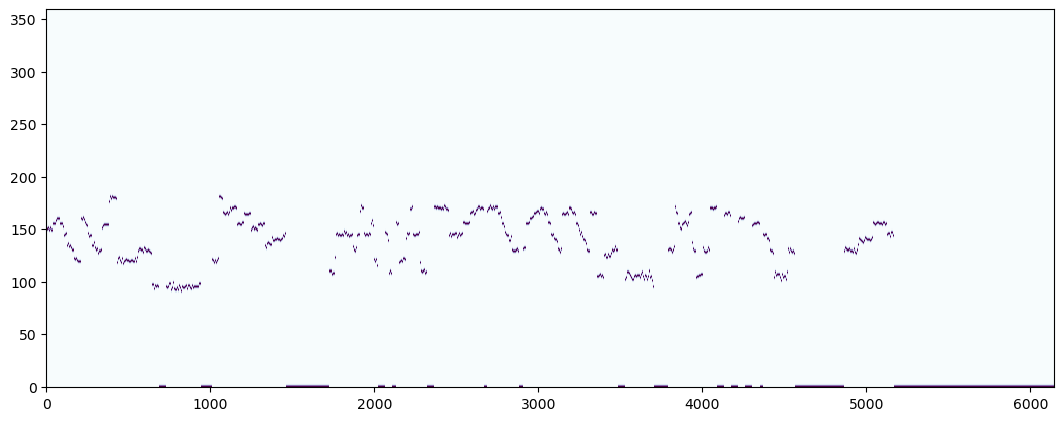

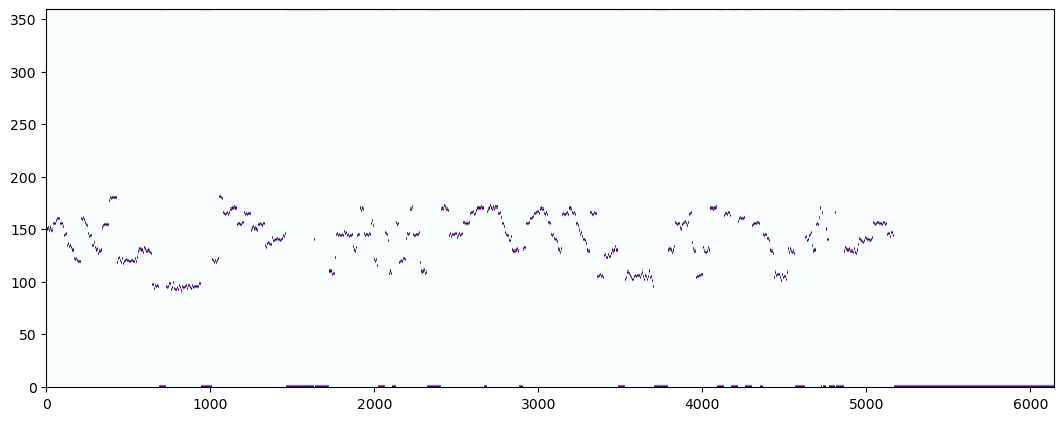

In [36]:
play_seq = SSCS_Sequence(sscs_get_split('test'))
mix, satb = play_seq.__getitem__(np.random.randint(0, play_seq.__len__() - 1))

mix = mix.numpy()
s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(satb[0].numpy(), 0, 1).reshape(360, -1)
a = np.moveaxis(satb[1].numpy(), 0, 1).reshape(360, -1)
t = np.moveaxis(satb[2].numpy(), 0, 1).reshape(360, -1)
b = np.moveaxis(satb[3].numpy(), 0, 1).reshape(360, -1)
s_pred = np.moveaxis(s_pred, 0, 1).reshape(360, -1)
a_pred = np.moveaxis(a_pred, 0, 1).reshape(360, -1)
t_pred = np.moveaxis(t_pred, 0, 1).reshape(360, -1)
b_pred = np.moveaxis(b_pred, 0, 1).reshape(360, -1)

s_argmax = np.argmax(s_pred, axis=0)
a_argmax = np.argmax(a_pred, axis=0)
t_argmax = np.argmax(t_pred, axis=0)
b_argmax = np.argmax(b_pred, axis=0)

s_thres = np.zeros((360, s_argmax.shape[0]))
a_thres = np.zeros((360, a_argmax.shape[0]))
t_thres = np.zeros((360, t_argmax.shape[0]))
b_thres = np.zeros((360, b_argmax.shape[0]))

for i in range(s_argmax.shape[0]):
    s_thres[s_argmax[i], i] = 1.0
    a_thres[a_argmax[i], i] = 1.0
    t_thres[t_argmax[i], i] = 1.0
    b_thres[b_argmax[i], i] = 1.0

s_pred_postproc = gaussian_filter1d(s_thres, 1, axis=0, mode='wrap')
a_pred_postproc = gaussian_filter1d(a_thres, 1, axis=0, mode='wrap')
t_pred_postproc = gaussian_filter1d(t_thres, 1, axis=0, mode='wrap')
b_pred_postproc = gaussian_filter1d(b_thres, 1, axis=0, mode='wrap')

idx = 10

sscs_plot(mix)
sscs_plot(s)
sscs_plot(s_pred_postproc)
#sscs_plot(s_pred)
sscs_plot(a)
sscs_plot(a_pred_postproc)
#sscs_plot(a_pred)
sscs_plot(t)
sscs_plot(t_pred_postproc)
#sscs_plot(t_pred)
sscs_plot(b)
sscs_plot(b_pred_postproc)
#sscs_plot(b_pred)